In [1]:
import numpy as np
import gurobipy as gp
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV

In [2]:
df_train = pd.read_csv('training_data.csv')
df_test = pd.read_csv('test_data.csv')

In [3]:
# Assuming df_train and df_test have columns for independent variables (X) and the dependent variable (y)
X_train = df_train.drop('y', axis=1).values
y_train = df_train['y'].values

X_test = df_test.drop('y', axis=1).values
y_test = df_test['y'].values

<div style="padding: 10px;">
    
**Setting up for K-fold validation**
    
</div>

In [4]:
# Define the number of variables and folds
num_variables = X_train.shape[1]
num_folds = 10

In [5]:
# Shuffle and split data into folds
np.random.seed(42)
indices = np.random.choice(range(len(X_train)), len(X_train), replace=False)
fold_indices = np.array_split(indices, num_folds)

In [6]:
# Define the range of k values to try
k_values = list(range(5, num_variables + 1, 5))
all_errors = []
M = 1000

# Initialize an empty list to store dictionaries with the information
cross_val_data = []

<div style="padding: 10px;">
    
## Mixed Integer Quadratic Programming:

*Decision Variables:*

1. m+1 $\beta$ **Continuous variables**:  $\beta_0, \beta_1, \ldots, \beta_m$
2. m $z$ **Binary variables**: $z_1, z_2, \ldots, z_m$

*Objective Variables:*
$$\quad \min_{\beta} \sum_{i=1}^{n} (\beta_i x_i - y_i)^2
$$

*Constraints:*

**Total number of constraints = 2m+1**

$$\sum_{i=1}^{m} z_i \leq k$$ 
$$ -z_i \cdot M \leq \beta_i \leq z_i \cdot M   \forall i \in \{1, \ldots, m\} $$
</div>

In [7]:
for k in tqdm(k_values, desc="K Values"):
    total_cv_error = 0
    for fold in tqdm(range(num_folds), desc="Folds", leave=False):
        # Split data into training and validation sets
        train_indices = np.concatenate([fold_indices[i] for i in range(num_folds) if i != fold])
        validation_indices = fold_indices[fold]
        
        # Set up Gurobi model
        model = gp.Model()
        
        # tell gurobi to shut up!!
        model.Params.OutputFlag = 0
        
        # Set time limit
        model.Params.TimeLimit = 60
        
        # Define decision variables - beta
        beta_0 = model.addMVar(1,lb=-np.inf)
        beta = model.addVars(num_variables, lb=-np.inf)
        
        # Define selection variables
        z = model.addVars(num_variables, vtype = 'B')
        
        # Define Objective
        model.setObjective(gp.quicksum((beta_0 + gp.quicksum(beta[i] * X_train[j, i] for i in range(num_variables)) - y_train[j])*
                                       (beta_0 + gp.quicksum(beta[i] * X_train[j, i] for i in range(num_variables)) - y_train[j])for j in train_indices))

        
        # Big-M consraint
        model.addConstrs((beta[i] <= M*z[i]) for i in range(num_variables))   
        model.addConstrs((beta[i] >= -M*z[i]) for i in range(num_variables))   
        
        # Constraint for selecting at most k variables
        model.addConstr(gp.quicksum(z[i] for i in range(num_variables)) <= k)
        
        # Solve the model
        model.optimize()
        
        # error from the fold dataset
        err = gp.quicksum(gp.quicksum((beta_0.x + gp.quicksum(beta[i].x * X_train[j, i] for i in range(num_variables)) - y_train[j])*
                                       (beta_0.x + gp.quicksum(beta[i].x * X_train[j, i] for i in range(num_variables)) - y_train[j])for j in validation_indices)).getValue()
        err = err/len(validation_indices)
        # Update total cross-validation error
        total_cv_error += err
        
        fold_data = {
            'k': k,
            'fold_number': fold,
            'error': err,
            'beta_0': beta_0.x,
            **{f'beta_{i}': beta[i].x for i in range(num_variables)}
        }

        # Append the dictionary to the list
        cross_val_data.append(fold_data)
        
    all_errors.append(total_cv_error)
    print(total_cv_error)
    
# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(cross_val_data)

# Save the DataFrame to a CSV file
df.to_csv('cross_val_logs.csv', index=False)

Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22



K Values:  10%|█         | 1/10 [00:13<01:58, 13.21s/it]A

36.561802520088065



K Values:  20%|██        | 2/10 [01:20<05:58, 44.80s/it]A

28.15864052573768



K Values:  30%|███       | 3/10 [06:55<20:42, 177.57s/it]

31.17559198664631



K Values:  40%|████      | 4/10 [14:59<29:49, 298.33s/it]

31.970539370796914



K Values:  50%|█████     | 5/10 [21:45<28:06, 337.24s/it]

31.293565179615634



K Values:  60%|██████    | 6/10 [25:10<19:29, 292.36s/it]

32.562044681590656



K Values:  70%|███████   | 7/10 [25:43<10:22, 207.43s/it]

32.69303959700011



K Values:  80%|████████  | 8/10 [25:54<04:50, 145.15s/it]

33.233558697859614



K Values:  90%|█████████ | 9/10 [26:04<01:42, 102.83s/it]

33.581251874928164



K Values: 100%|██████████| 10/10 [26:13<00:00, 157.34s/it]

33.618160621779445


In [8]:
all_errors

[36.561802520088065,
 28.15864052573768,
 31.17559198664631,
 31.970539370796914,
 31.293565179615634,
 32.562044681590656,
 32.69303959700011,
 33.233558697859614,
 33.581251874928164,
 33.618160621779445]

In [9]:
# Determining the best k using miqp
df = pd.read_csv("cross_val_logs.csv")

<div style="padding: 10px;">
    
## Graph 1 - Test SSE comparision for MIQP for different values of K ##
    
</div>

In [10]:
# Show values for MSE for different K's
df[['k','error']].groupby('k').sum().sort_values(ascending=True,by='error')

,error
k,
10,28.158641
15,31.175592
25,31.293565
20,31.970539
30,32.562045
35,32.693040
40,33.233559
45,33.581252
50,33.618161


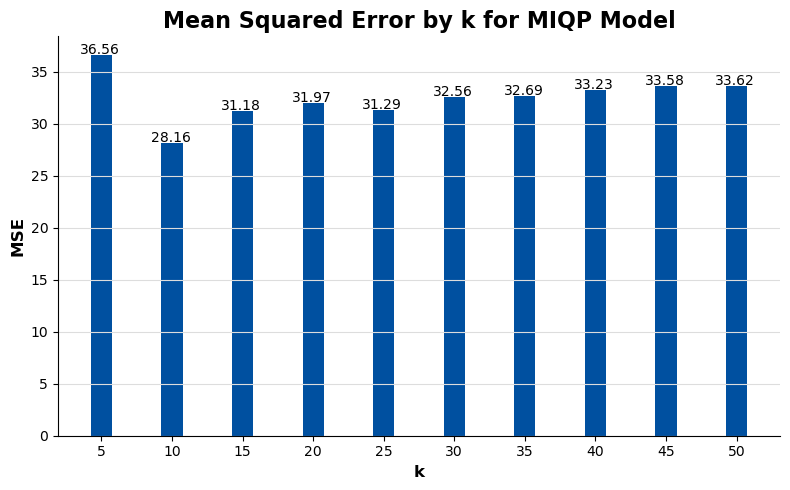

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a dark blue and grey color palette
colors = ['#0050a0', '#95a5a6']
sns.set_palette(sns.color_palette(colors))

# Group by 'k' and sum the 'mse' values, then sort by 'mse'
grouped_data = df[['k', 'error']].groupby('k').sum().sort_values(by='error')

# Increase the bar width
bar_width = 1.5  # Adjust this value according to your preference

# Create a bar graph
plt.figure(figsize=(8, 5)) 
bars = plt.bar(grouped_data.index, grouped_data['error'], width=bar_width)

# Add value annotations on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1, f'{bar.get_height():.2f}', ha='center', color='black', fontsize=10)

# Customize the plot
plt.xlabel('k', fontsize=12, fontweight='bold', color='#000000')
plt.ylabel('MSE', fontsize=12, fontweight='bold', color='#000000')
plt.title('Mean Squared Error by k for MIQP Model', fontsize=16, fontweight='bold', color='#000000')

# Set x tick positions without alternating
plt.xticks(grouped_data.index, fontsize=10, color='#000000')

plt.yticks(fontsize=10, color='#000000')
plt.grid(axis='y', color='#dddddd')

# Remove the top and right spines for a cleaner look
sns.despine(top=True, right=True)

# Show the plot
plt.tight_layout()
plt.show()


<div style="padding: 10px;">
    
**k=10** is the best value from cross validation since it has the **least MSE** - we try and fit our MIQP model for that

</div>

In [13]:
# Fitting the model for k=10
k = 10

# Set up Gurobi model
model = gp.Model()
        
# tell gurobi to shut up!!
model.Params.OutputFlag = 0
        
# Set time limit
model.Params.TimeLimit = 5
        
# Define decision variables - beta
beta_0 = model.addMVar(1,lb=-np.inf)
beta = model.addVars(num_variables, lb=-np.inf)
        
# Define selection variables
z = model.addVars(num_variables, vtype = 'B')
        
# Define Objective
model.setObjective(gp.quicksum((beta_0 + gp.quicksum(beta[i] * X_train[j, i] for i in range(num_variables)) - y_train[j])*
                                (beta_0 + gp.quicksum(beta[i] * X_train[j, i] for i in range(num_variables)) - y_train[j])for j in range(len(X_train))))

        
# Big-M consraint
model.addConstrs((beta[i] <= M*z[i]) for i in range(num_variables))   
model.addConstrs((beta[i] >= -M*z[i]) for i in range(num_variables))   
        
# Constraint for selecting at most k variables
model.addConstr(gp.quicksum(z[i] for i in range(num_variables)) <= k)
        
# Solve the model
model.optimize()
        
# train error
err_train = gp.quicksum(gp.quicksum((beta_0.x + gp.quicksum(beta[i].x * X_train[j, i] for i in range(num_variables)) - y_train[j])*
                                (beta_0.x + gp.quicksum(beta[i].x * X_train[j, i] for i in range(num_variables)) - y_train[j])for j in range(len(X_train)))).getValue()
err_train = err_train/len(X_train)

# test error
err_test = gp.quicksum(gp.quicksum((beta_0.x + gp.quicksum(beta[i].x * X_test[j, i] for i in range(num_variables)) - y_test[j])*
                                (beta_0.x + gp.quicksum(beta[i].x * X_test[j, i] for i in range(num_variables)) - y_test[j])for j in range(len(X_test)))).getValue()
err_test = err_test/len(X_test)

print(err_train)
print(err_test)

2.391985266291457
2.3365439645525234


In [14]:
beta_miqp = [var.x for var in beta.values()]
beta_miqp = np.array(beta_miqp)

<div style="padding: 10px;">

**Lasso:**
   
Use scikit learn to do 10-fold cross validation on the training set to pick lambda. Once you find the best value of lambda, fit a LASSO model to the entire training set using that value of lambda. With the betas you find in that LASSO model make a prediction of the y values in the test set
</div>

In [15]:
X_train = np.array(df_train.iloc[0:,1:])
y_train = np.array(df_train['y'])
X_test = np.array(df_test.iloc[0:,1:])
y_test = np.array(df_test['y'])

# standardizing the dataset
from sklearn.preprocessing import StandardScaler

# fitting on x train
std_trans = StandardScaler()
std_trans.fit(X_train)

#transforming on X_train and X_test
X_train_std = std_trans.transform(X_train)
X_test_std = std_trans.transform(X_test)

#using LassoCv to get the best lambda(regularization penalty) and training the data with this value
lassocv = LassoCV(alphas = None, cv = 10)
lassocv.fit(X_train_std, y_train)

lasso=Lasso()

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train_std, y_train)

#predict on test data
y_pred_train_l=lasso.predict(X_train_std)

#predict on test data
y_pred_l=lasso.predict(X_test_std)

#calculate SSE on train
#squared_train_error_lasso = sum((y_pred_train_l-y_train)**2)
squared_train_error_lasso = mean_squared_error(y_pred_train_l, y_train)
#calculate SSE on train
squared_test_error_lasso = mean_squared_error(y_pred_l, y_test)

#print best lambda value
print('Best Value of lambda:',lassocv.alpha_ )

#Train_SSE
print('SSE on train data for Lasso:',str(round(squared_train_error_lasso,5)))

#Test_SSE
print('SSE on test data for Lasso:',str(round(squared_test_error_lasso,5)))

# calculating number of features
print('Total non-zero features using Lasso:', (lassocv.coef_ != 0).sum())

Best Value of lambda: 0.08471942409934509
SSE on train data for Lasso: 2.38644
SSE on test data for Lasso: 2.35667
Total non-zero features using Lasso: 18


In [16]:
#extracting the beta values for lasso
beta_lasso=lassocv.coef_
beta_lasso

array([-0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -2.71982685,  0.        ,
       -0.05745334, -0.        , -0.        , -0.        , -0.39585533,
       -0.23276644,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.22180365, -1.15847952,  0.77569425, -0.        ,
       -1.27950133,  0.        ,  0.        ,  0.06530332,  0.        ,
       -0.        ,  0.        , -0.10847216,  0.25740072,  0.01277731,
        0.        ,  0.        ,  0.        , -0.18839793,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.0186891 ,  1.63196351,
       -0.01838965,  0.69384574, -0.08473514,  0.        ,  0.        ])

<div style="padding: 10px;">
    
## Graph 2 - SSE comparision across train and test in both the model ##
    
</div>

<Figure size 800x500 with 0 Axes>

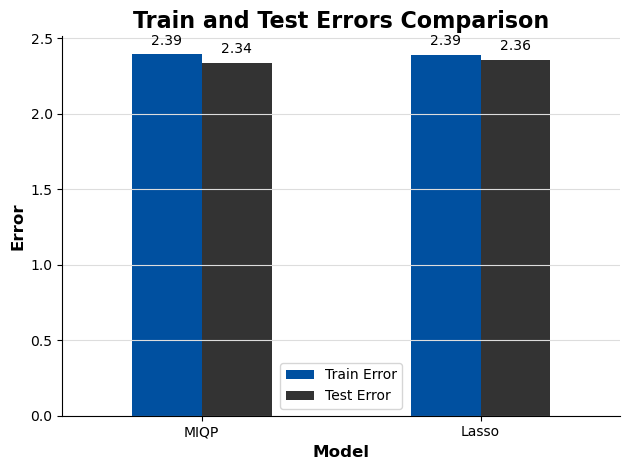

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a dark blue, grey, and black color palette
colors = ['#0050a0', '#333333', '#000000']
sns.set_palette(sns.color_palette(colors))

# Data for SSE
SSE = {
    'Model': ['MIQP', 'Lasso'],
    'Train Error': [err_train, squared_train_error_lasso],
    'Test Error': [err_test, squared_test_error_lasso]
}

# Create a DataFrame
df_SSE = pd.DataFrame(SSE)

# Create a bar graph
plt.figure(figsize=(8, 5))
ax = df_SSE.set_index('Model').plot(kind='bar', rot=0)

# Add value annotations on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black', fontsize=10)

# Customize the plot
plt.xlabel('Model', fontsize=12, fontweight='bold', color='#000000')
plt.ylabel('Error', fontsize=12, fontweight='bold', color='#000000')
plt.title('Train and Test Errors Comparison', fontsize=16, fontweight='bold', color='#000000')
plt.xticks(fontsize=10, color='#000000')
plt.yticks(fontsize=10, color='#000000')
plt.grid(axis='y',color='#dddddd')

# Remove the top and right spines for a cleaner look
sns.despine(top=True, right=True)

# Show the plot
plt.tight_layout()
plt.show()


<div style="padding: 10px;">
    
## Graph 3 - $\beta$ comparision in both the model ##
    
</div>

<Figure size 800x500 with 0 Axes>

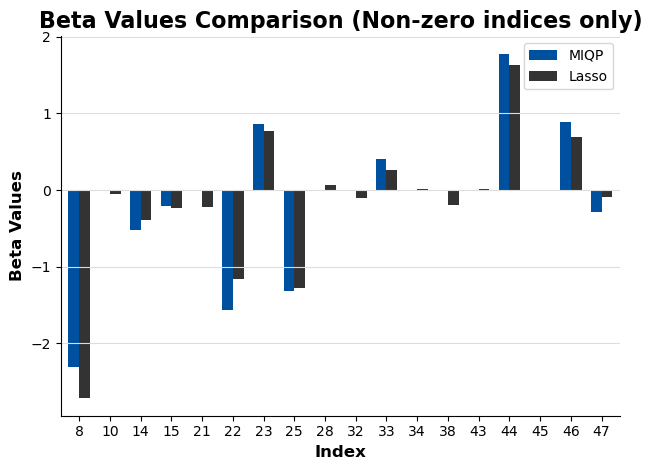

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a dark blue, grey, and black color palette
colors = ['#0050a0', '#333333', '#000000']
sns.set_palette(sns.color_palette(colors))

# Check if at least one of the methods has a non-zero beta at each index
non_zero_indices = np.logical_or(beta_miqp != 0, beta_lasso != 0)

# Create an array of indices for non-zero elements
indices = np.arange(len(beta))[non_zero_indices]

# Create a DataFrame with non-zero beta values and corresponding indices
data = {'Index': indices, 'MIQP': beta_miqp[non_zero_indices], 'Lasso': beta_lasso[non_zero_indices]}
df = pd.DataFrame(data)

# Create a bar graph
plt.figure(figsize=(8, 5))
ax = df.plot(x='Index', kind='bar', rot=0, width=0.7)

"""# Add value annotations on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2 - 0.1, p.get_height() + 0.1),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black', fontsize=10, fontweight='bold')
"""

# Customize the plot
plt.xlabel('Index', fontsize=12, fontweight='bold', color='#000000')
plt.ylabel('Beta Values', fontsize=12, fontweight='bold', color='#000000')
plt.title('Beta Values Comparison (Non-zero indices only)', fontsize=16, fontweight='bold', color='#000000')
plt.xticks(fontsize=10, color='#000000')
plt.yticks(fontsize=10, color='#000000')
plt.grid(axis='y', color='#dddddd')

# Remove the top and right spines for a cleaner look
sns.despine(top=True, right=True)

# Show the plot
plt.tight_layout()
plt.show()


<div style="padding: 10px;">
    
## Graph 4 - Predicted Output in both the model versus Actual Output ##
    
</div>

In [26]:
df_test_copy = df_test
df_test['intercept'] = 1
#beta_miqp = np.append(beta_miqp,beta_0.x) # Run only once
y_pred = df_test.iloc[:,1:].dot(beta_miqp)

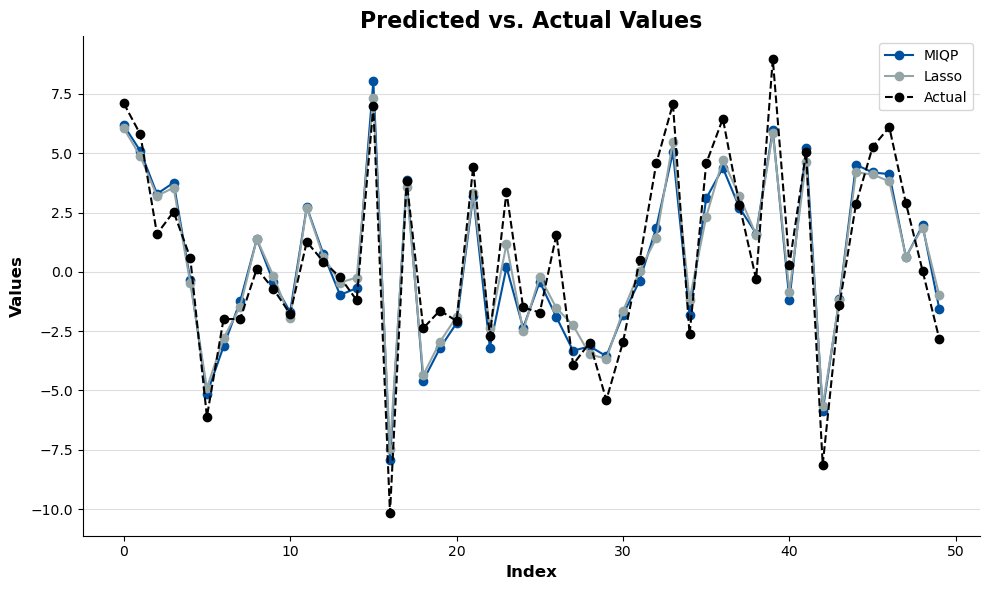

In [28]:
# Set a dark blue, grey, and black color palette
colors = ['#0050a0', '#95a5a6', '#000000']
sns.set_palette(sns.color_palette(colors))

# Create a range of indices
indices = range(len(y_pred))

# Plot the predicted values from MIQP and Lasso models
plt.figure(figsize=(10, 6))
plt.plot(indices, y_pred, label='MIQP', marker='o', linestyle='-', color=colors[0])
plt.plot(indices, y_pred_l, label='Lasso', marker='o', linestyle='-', color=colors[1])

# Plot the actual values as dotted lines
plt.plot(indices, y_test, label='Actual', marker='o', linestyle='--', color=colors[2])

# Customize the plot
plt.xlabel('Index', fontsize=12, fontweight='bold', color=colors[2])
plt.ylabel('Values', fontsize=12, fontweight='bold', color=colors[2])
plt.title('Predicted vs. Actual Values', fontsize=16, fontweight='bold', color=colors[2])
plt.xticks(fontsize=10, color=colors[2])
plt.yticks(fontsize=10, color=colors[2])
plt.grid(axis='y', color='#dddddd')

# Remove the top and right spines for a cleaner look
sns.despine(top=True, right=True)

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
